#### Visual study of the ground-truth and predicted labels
This code plots and saves the images containing a certain label among its predicted labels. It saves the images to the res folder. Thought to be used for visual examination of the vsual relevance of the predictions (i.e. if the model is learning anything at all).

In [1]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt

Plot images with their ground-truth labels, and predicted labels

In [2]:
i = 0
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]

In [3]:
test_df = pd.read_json(config['data_folder'] + '/test_df.json.bz2', compression='bz2')

test = hf.get_flow(df=test_df,
                   nr_classes=config['nr_classes'],
                   image_dimension=config['image_dimension'])


Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.


In [ ]:
# Create model
model = hf.create_model(n_labels=config['nr_classes'], image_dimension=config['image_dimension'], model_name=config['basemodel'], number_trainable_layers=config['number_trainable_layers'])
latest = tf.train.latest_checkpoint(config['results_folder'] + '/checkpoints')
model.load_weights(latest)
# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=1)
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
# Get optimal thresholds
val_threshold = hf.get_flow(df_file=config['data_folder'] + '/val_threshold_df.json.bz2',
                            nr_classes=config['nr_classes'],
                            image_dimension=config['image_dimension'])
# Predict on validation set
print('Predicting on validation set:\n')
probs_val = model.predict(val_threshold, verbose=1)
y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)
optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                            probs=probs_val, 
                                            thresholds=np.linspace(start=0, stop=1, num=21), 
                                            labels=list(val_threshold.class_indices.keys()), 
                                            N=7,
                                            image_path=config['results_folder'])
y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)

In [5]:
del model
del optim_thresholds
del y_true_test
del probs_test
del probs_val
del y_true_val 

In [15]:
teeeest = 'History'
'thesis_experiments/images_pred_and_gt' + '/' + teeeest + '.png' 

'thesis_experiments/images_pred_and_gt/History.png'

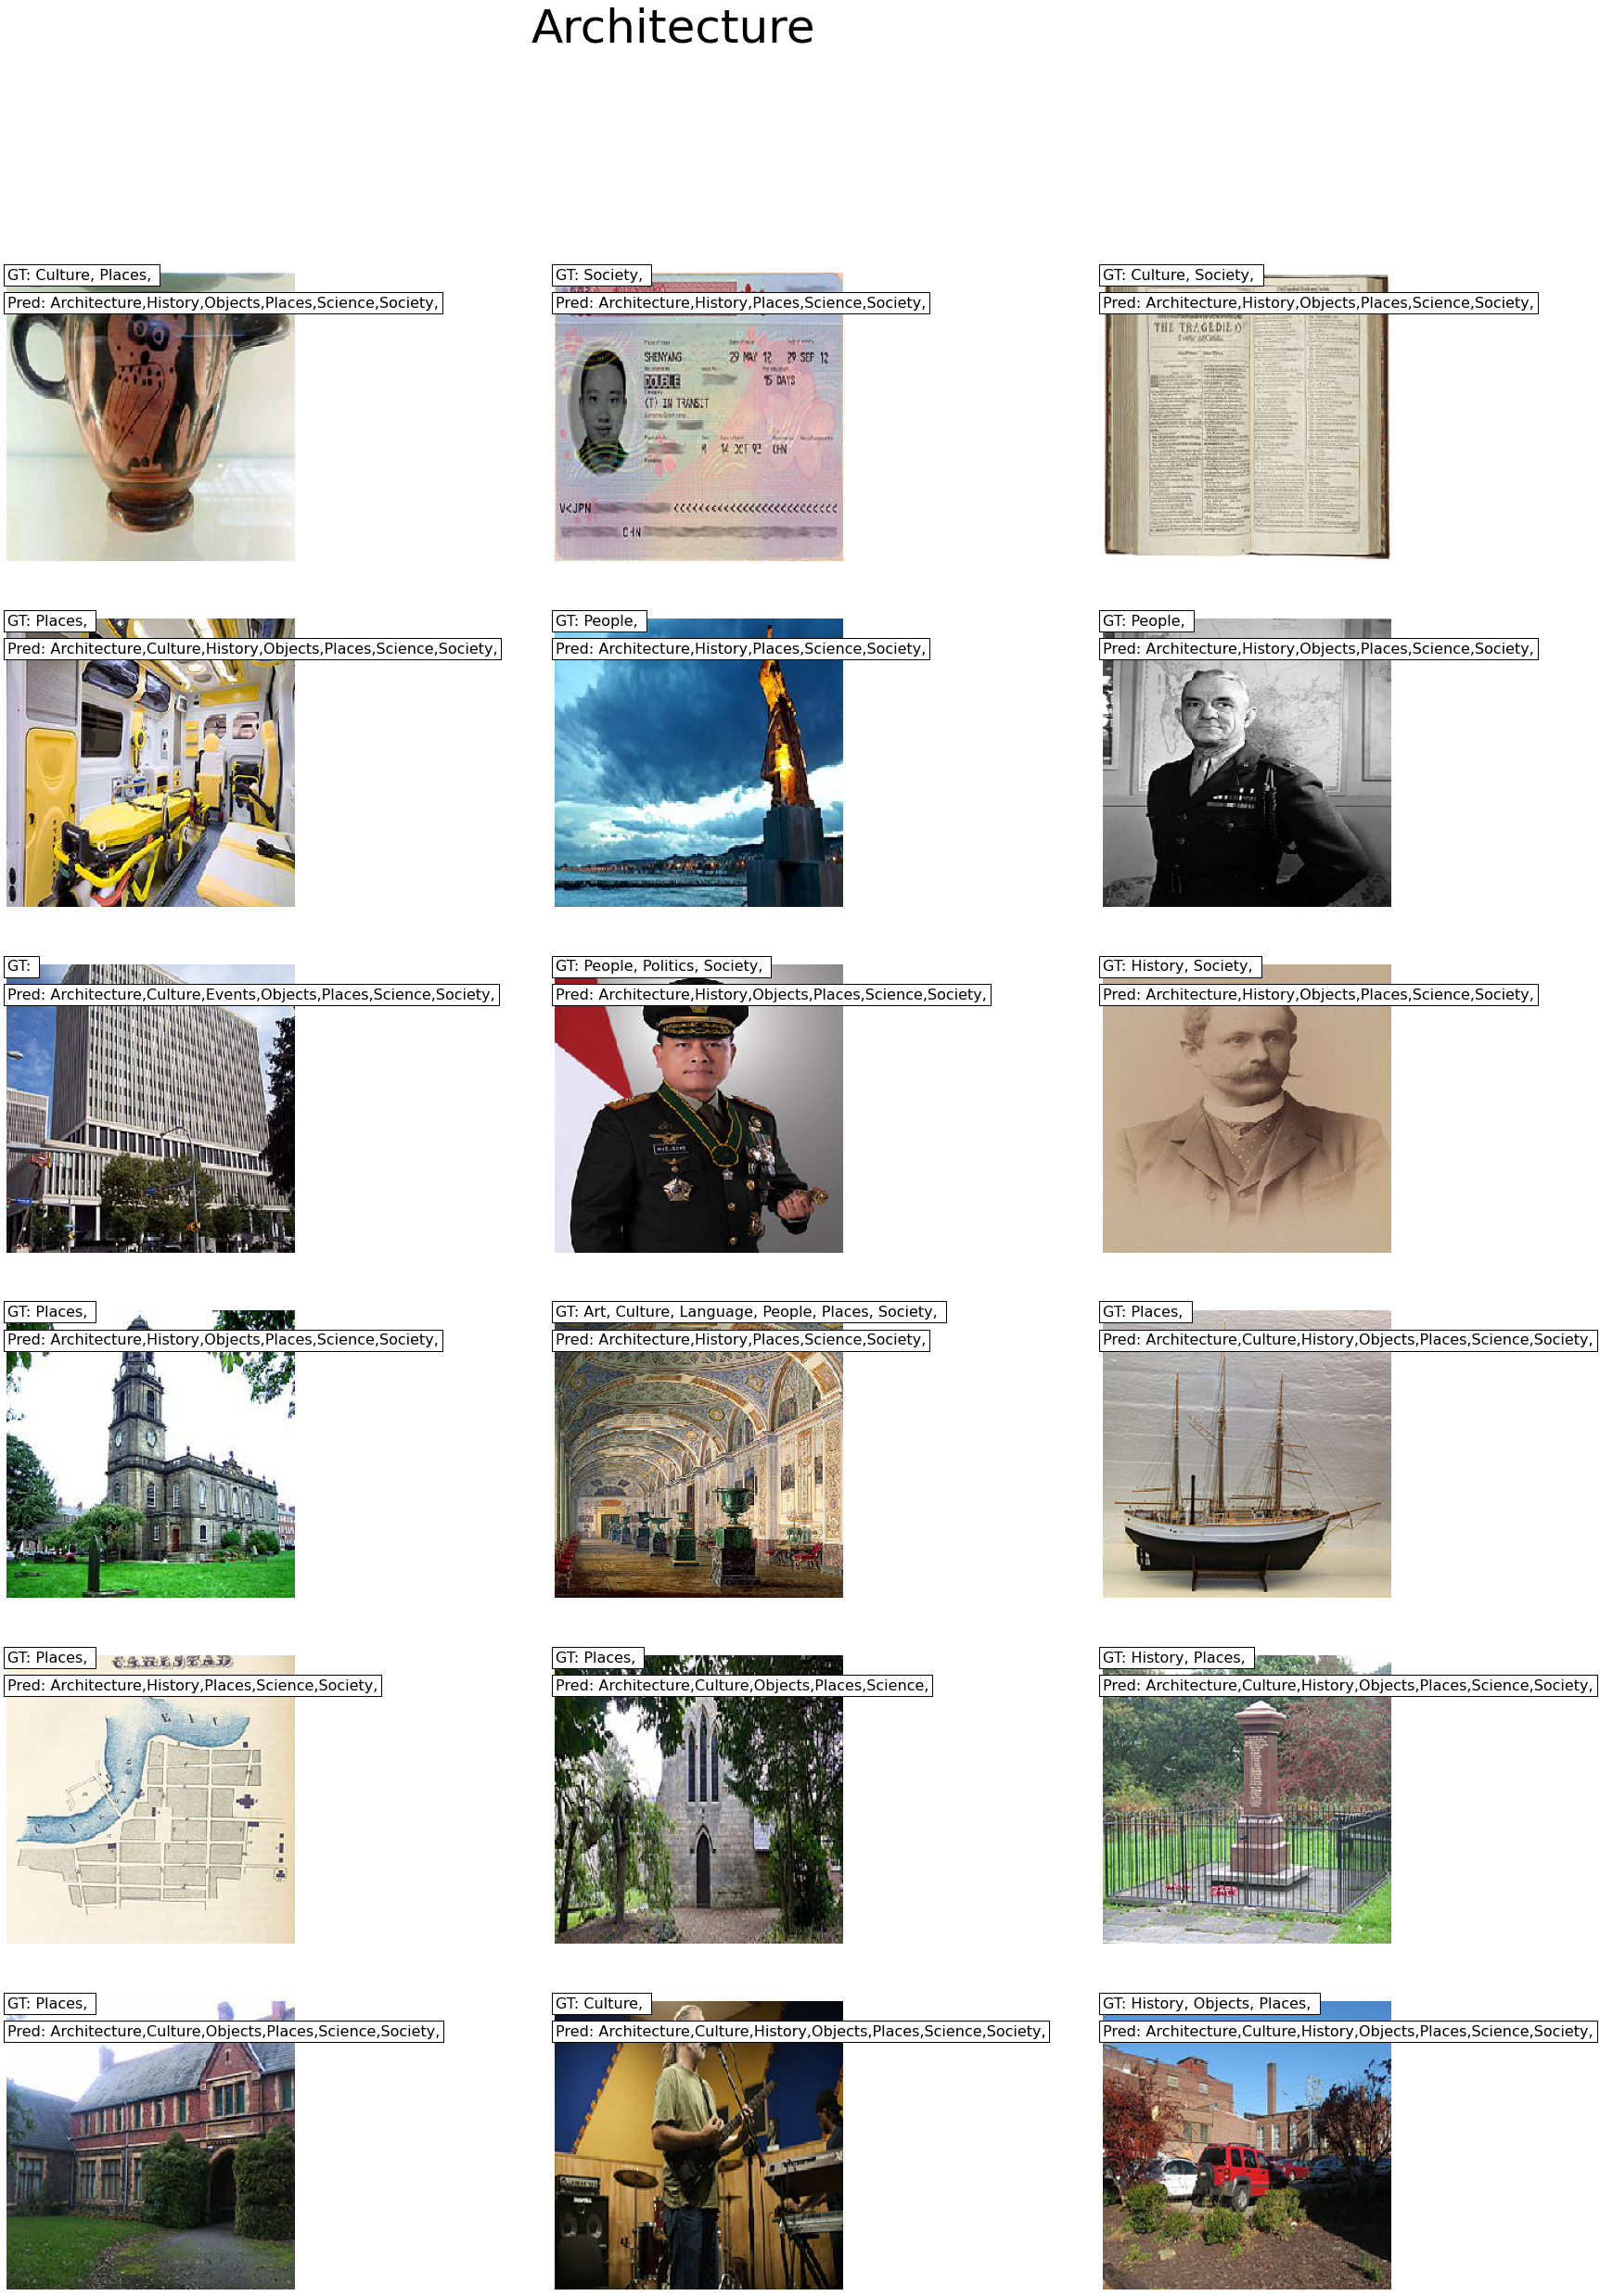

In [18]:
from tensorflow.keras.preprocessing.image import load_img

label_names = np.array(list(test.class_indices.keys()))

def get_images_from_label(wished_label, img_path):

    wished_label_idx = list(test.class_indices.keys()).index(wished_label)

    columns = 3
    rows = 6
    fig, axs = plt.subplots(rows, columns, figsize=(30, 40))
    indices_with_image = np.argwhere(y_pred_test_per_class_threshold[:, wished_label_idx] == 1).flatten()
    random_indices = np.random.choice(indices_with_image, rows*columns)

    for i, idx, ax in zip(range(len(random_indices)), random_indices, axs.flatten()):#enumerate(random_indices):
        path = '/scratch/WIT_Dataset/images/' + test_df.iloc[idx, :].url
        img = load_img(path, target_size=(256, 256))
        # plt.subplot(rows, columns, i + 1)
        ax.imshow(img)
        ax.axis('off')
        gt_str = 'GT: '
        gt_labels = test_df.iloc[idx, :].labels
        gt_labels.sort()
        gt_str += ''.join([label + ', ' for label in gt_labels])
        ax.text(x=0, y=5, s=gt_str, fontsize=16, bbox=dict(facecolor='white', edgecolor='black'))

        mask = [x == 1 for x in y_pred_test_per_class_threshold[idx, :]]
        predicted_labels = label_names[mask]
        predicted_labels_str = 'Pred: '
        predicted_labels_str += ''.join([label + ',' for label in predicted_labels])
        ax.text(x=0, y=30, s=predicted_labels_str, fontsize=16, bbox=dict(facecolor='white', edgecolor='black'))

    plt.suptitle(wished_label, fontsize=50)

    plt.savefig(img_path + '/' + wished_label + '.png')

for label in label_names:
    get_images_from_label(label, 'thesis_experiments/images_pred_and_gt')
